c:\Users\user\Desktop\coffee_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\Desktop\coffee_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [07:08<00:00, 109kB/s] 


Epoch 1/30, Train Loss: 0.6719, Val Loss: 0.7847
Epoch 2/30, Train Loss: 0.3939, Val Loss: 1.0604
Epoch 3/30, Train Loss: 0.3183, Val Loss: 0.5891
Epoch 4/30, Train Loss: 0.2997, Val Loss: 0.3846
Epoch 5/30, Train Loss: 0.2385, Val Loss: 0.5359
Epoch 6/30, Train Loss: 0.1462, Val Loss: 0.2872
Epoch 7/30, Train Loss: 0.1303, Val Loss: 0.3467
Epoch 8/30, Train Loss: 0.1291, Val Loss: 0.4323
Epoch 9/30, Train Loss: 0.0942, Val Loss: 0.3464
Epoch 10/30, Train Loss: 0.1048, Val Loss: 0.7580
Epoch 11/30, Train Loss: 0.0780, Val Loss: 0.3345
Early stopping triggered.


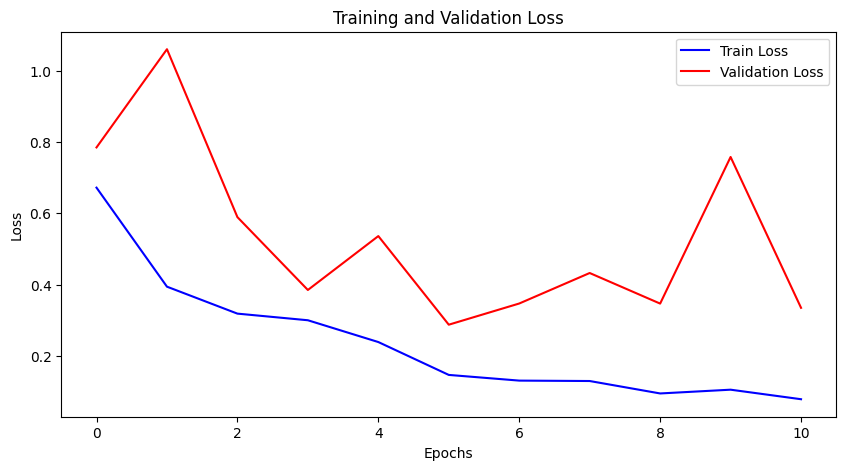

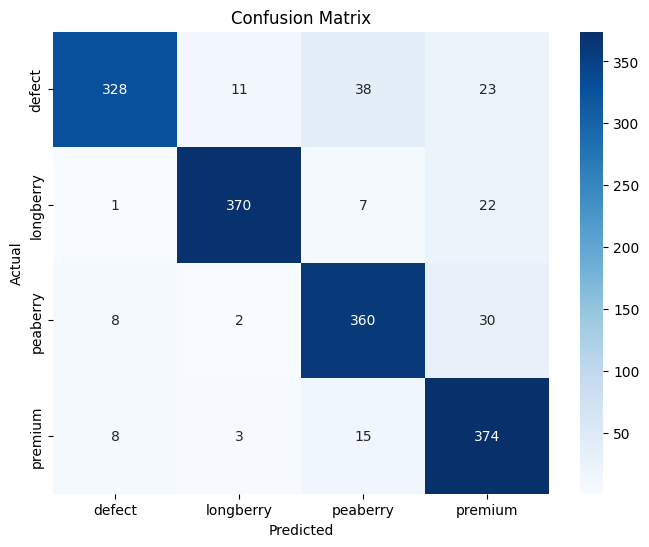

Classification Report:
               precision    recall  f1-score   support

      defect       0.95      0.82      0.88       400
   longberry       0.96      0.93      0.94       400
    peaberry       0.86      0.90      0.88       400
     premium       0.83      0.94      0.88       400

    accuracy                           0.90      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.90      0.90      1600



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

# Define transformations with data augmentation
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
data_dir = "C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=data_transforms)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=data_transforms)

# Compute class weights for balanced sampling
class_counts = Counter(train_dataset.targets)
num_samples = sum(class_counts.values())
weights = {class_idx: num_samples/class_counts[class_idx] for class_idx in class_counts.keys()}
sample_weights = [weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pretrained Model (ResNet-18)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Adjust output layer

# Define loss function with class weights
class_weights = torch.tensor([weights[i] for i in range(len(weights))], dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
num_epochs = 30
early_stopping_patience = 5
train_losses, val_losses = [], []
best_val_loss = np.inf
patience = 0

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step()
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience = 0
    else:
        patience += 1
        if patience >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model on validation set
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_dataset.classes))
